# Notebook 05: A/B Testing Analysis

### Compare two summarization models and determine which performs bette

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from rouge_score import rouge_scorer
import requests
import os
from dotenv import load_dotenv
import time

In [2]:
load_dotenv()
HF_API_KEY = os.getenv('HUGGINGFACE_API_KEY')

## A/B TESTING: MODEL COMPARISON

In [3]:
# ================================
# 1. DEFINE HYPOTHESIS
# ================================

print("\n EXPERIMENTAL DESIGN")
print("-" * 60)
print("\nHypothesis:")
print("  H0: No significant difference between Model A and Model B")
print("  H1: Model B produces significantly better summaries than Model A")
print("\nModels:")
print("  Model A (Control): facebook/bart-large-cnn")
print("  Model B (Treatment): DistilBART (alternative summarization approach)")
print("\nMetrics:")
print("  1. ROUGE scores (automated)")
print("  2. User preference (will be collected via Streamlit app)")
print("  3. Generation latency")
print("  4. Summary length")



 EXPERIMENTAL DESIGN
------------------------------------------------------------

Hypothesis:
  H0: No significant difference between Model A and Model B
  H1: Model B produces significantly better summaries than Model A

Models:
  Model A (Control): facebook/bart-large-cnn
  Model B (Treatment): DistilBART (alternative summarization approach)

Metrics:
  1. ROUGE scores (automated)
  2. User preference (will be collected via Streamlit app)
  3. Generation latency
  4. Summary length


In [4]:
# ================================
# 2. LOAD TEST DATA
# ================================

print("\n" + "="*60)
print("PREPARING TEST DATASET")
print("="*60)

df = pd.read_csv('../data/arxiv_papers_clean.csv')

# Sample papers for testing (stratified by category for diversity)
np.random.seed(42)
test_sample = df.sample(n=min(50, len(df)), random_state=42)

print(f"✓ Selected {len(test_sample)} papers for A/B testing")
print(f"  Categories represented: {test_sample['categories'].str.split(', ').explode().nunique()}")


PREPARING TEST DATASET
✓ Selected 50 papers for A/B testing
  Categories represented: 29


In [5]:
# ================================
# 3. SUMMARIZATION FUNCTIONS
# ================================

def summarize_model_a(text, max_length=130):
    """Model A: BART-large-cnn"""
    API_URL = "https://api-inference.huggingface.co/models/facebook/bart-large-cnn"
    headers = {"Authorization": f"Bearer {HF_API_KEY}"}
    
    if len(text.split()) > 500:
        text = ' '.join(text.split()[:500])
    
    payload = {
        "inputs": text,
        "parameters": {"max_length": max_length, "min_length": 30, "do_sample": False}
    }
    
    try:
        start = time.time()
        response = requests.post(API_URL, headers=headers, json=payload, timeout=30)
        latency = time.time() - start
        
        if response.status_code == 200:
            result = response.json()
            if isinstance(result, list) and len(result) > 0:
                # BART typically uses 'summary_text'
                return result[0].get('summary_text', ''), latency
        
        # Handle model loading
        if response.status_code == 503:
            print("  Model A loading... waiting 20 seconds...")
            time.sleep(20)
            start_retry = time.time()
            response = requests.post(API_URL, headers=headers, json=payload, timeout=30)
            latency = time.time() - start_retry
            
            if response.status_code == 200:
                result = response.json()
                if isinstance(result, list) and len(result) > 0:
                    # Note: Used 'generated_text' from your original code in the retry path,
                    # but typically BART outputs 'summary_text'. Changed to 'summary_text' for consistency.
                    return result[0].get('summary_text', ''), latency
        
        # FIX: Return empty string and latency for any non-200/non-retry-success status code
        return "", latency 
        
    except Exception as e:
        # FIX: Return empty string and 0.0 latency for connection/timeout errors
        print(f"  Model A Exception: {e}")
        return "", 0.0


def summarize_model_b(text, max_length=130):
    """Model B: DistilBART (fast summarization model)"""
    # NOTE: Using a highly reliable and faster BART-based model
    API_URL = "https://api-inference.huggingface.co/models/sshleifer/distilbart-cnn-12-6"
    headers = {"Authorization": f"Bearer {HF_API_KEY}"}
    
    if len(text.split()) > 500:
        text = ' '.join(text.split()[:500])
    
    # DistilBART does NOT require the "summarize: " prefix
    # Removed: text_with_prefix = f"summarize: {text}"
    
    payload = {
        "inputs": text,
        # Using parameters optimized for BART-style models
        "parameters": {"max_length": max_length, "min_length": 30, "do_sample": False}
    }
    
    try:
        start = time.time()
        response = requests.post(API_URL, headers=headers, json=payload, timeout=30)
        latency = time.time() - start
        
        if response.status_code == 200:
            result = response.json()
            if isinstance(result, list) and len(result) > 0:
                # DistilBART is likely to use 'summary_text'
                return result[0].get('summary_text', ''), latency
        
        # Handle model loading
        if response.status_code == 503:
            print("  Model B loading... waiting 20 seconds...")
            time.sleep(20)
            start_retry = time.time()
            response = requests.post(API_URL, headers=headers, json=payload, timeout=30)
            latency = time.time() - start_retry
            
            if response.status_code == 200:
                result = response.json()
                if isinstance(result, list) and len(result) > 0:
                    return result[0].get('summary_text', ''), latency # Use 'summary_text'
            
            # Print failure status after retry
            print(f"  Model B FAILED RETRY: Status {response.status_code}")
            return "", latency

        # Print failure status immediately
        print(f"  Model B IMMEDIATE FAILURE: Status {response.status_code}")
        return "", latency # FIX: Return empty string and latency if all attempts fail
        
    except Exception as e:
        print(f"  Model B Exception: {e}")
        return "", 0.0 # FIX: Return empty string and 0.0 latency on exception

In [6]:

# ================================
# 4. GENERATE SUMMARIES FOR BOTH MODELS
# ================================

print("\n" + "="*60)
print("GENERATING SUMMARIES")
print("="*60)

results = []

# Take smaller sample for demonstration
sample_papers = test_sample.head(25)  # Reduce for faster execution

for idx, row in sample_papers.iterrows():
    print(f"\nProcessing paper {len(results) + 1}/{len(sample_papers)}...")
    print(f"  Title: {row['title'][:60]}...")
    
    abstract = row['abstract_clean']
    
    # Generate with Model A
    summary_a, latency_a = summarize_model_a(abstract)
    time.sleep(1)  # Rate limiting
    
    # Generate with Model B
    summary_b, latency_b = summarize_model_b(abstract)
    time.sleep(1)  # Rate limiting
    
    if summary_a and summary_b:
        results.append({
            'paper_id': idx,
            'title': row['title'],
            'abstract': abstract,
            'summary_a': summary_a,
            'summary_b': summary_b,
            'latency_a': latency_a,
            'latency_b': latency_b,
            'length_a': len(summary_a.split()),
            'length_b': len(summary_b.split())
        })
        print(f"  ✓ Model A: {len(summary_a.split())} words, {latency_a:.2f}s")
        print(f"  ✓ Model B: {len(summary_b.split())} words, {latency_b:.2f}s")

df_results = pd.DataFrame(results)
print(f"\n✅ Generated {len(df_results)} summary pairs")

# Save results
df_results.to_csv('../data/ab_test_summaries.csv', index=False)
print("✓ Saved to ../data/ab_test_summaries.csv")


GENERATING SUMMARIES

Processing paper 1/25...
  Title: A Survey From Distributed Machine Learning to Distributed De...
  ✓ Model A: 37 words, 1.68s
  ✓ Model B: 43 words, 2.39s

Processing paper 2/25...
  Title: Towards Optimal Head-to-head Autonomous Racing with Curricul...
  ✓ Model A: 25 words, 2.03s
  ✓ Model B: 30 words, 1.24s

Processing paper 3/25...
  Title: PoBRL: Optimizing Multi-Document Summarization by Blending R...
  ✓ Model A: 34 words, 1.76s
  ✓ Model B: 35 words, 2.38s

Processing paper 4/25...
  Title: A Novel Update Mechanism for Q-Networks Based On Extreme Lea...
  ✓ Model A: 58 words, 2.68s
  ✓ Model B: 53 words, 1.64s

Processing paper 5/25...
  Title: L2Explorer: A Lifelong Reinforcement Learning Assessment Env...
  ✓ Model A: 51 words, 1.79s
  ✓ Model B: 72 words, 2.14s

Processing paper 6/25...
  Title: Kernel Machines With Missing Responses...
  ✓ Model A: 39 words, 1.64s
  ✓ Model B: 42 words, 1.44s

Processing paper 7/25...
  Title: Generalization in Trans

In [7]:


# ================================
# 5. AUTOMATED EVALUATION: ROUGE SCORES
# ================================

print("\n" + "="*60)
print("ROUGE SCORE EVALUATION")
print("="*60)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores_a = []
rouge_scores_b = []

for _, row in df_results.iterrows():
    # Use abstract as reference (since we don't have human-written summaries)
    reference = row['abstract']
    
    # Score Model A
    scores_a = scorer.score(reference, row['summary_a'])
    rouge_scores_a.append({
        'rouge1': scores_a['rouge1'].fmeasure,
        'rouge2': scores_a['rouge2'].fmeasure,
        'rougeL': scores_a['rougeL'].fmeasure
    })
    
    # Score Model B
    scores_b = scorer.score(reference, row['summary_b'])
    rouge_scores_b.append({
        'rouge1': scores_b['rouge1'].fmeasure,
        'rouge2': scores_b['rouge2'].fmeasure,
        'rougeL': scores_b['rougeL'].fmeasure
    })

df_rouge_a = pd.DataFrame(rouge_scores_a)
df_rouge_b = pd.DataFrame(rouge_scores_b)

print("\nModel A (BART) - Average ROUGE Scores:")
print(df_rouge_a.mean())

print("\nModel B (DistilBART5) - Average ROUGE Scores:")
print(df_rouge_b.mean())






ROUGE SCORE EVALUATION

Model A (BART) - Average ROUGE Scores:
rouge1    0.528681
rouge2    0.511101
rougeL    0.521560
dtype: float64

Model B (DistilBART5) - Average ROUGE Scores:
rouge1    0.517385
rouge2    0.492548
rougeL    0.512286
dtype: float64


In [8]:


# ================================
# 6. STATISTICAL TESTING
# ================================

print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*60)

# Paired t-test for ROUGE-1
t_stat, p_value = stats.ttest_rel(df_rouge_a['rouge1'], df_rouge_b['rouge1'])

print(f"\nPaired t-test (ROUGE-1):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significance level: α = 0.05")

if p_value < 0.05:
    winner = "Model A" if t_stat > 0 else "Model B"
    print(f"  ✓ Result: {winner} is significantly better")
else:
    print(f"  ✗ Result: No significant difference detected")

# Effect size (Cohen's d)
mean_diff = df_rouge_a['rouge1'].mean() - df_rouge_b['rouge1'].mean()
pooled_std = np.sqrt((df_rouge_a['rouge1'].std()**2 + df_rouge_b['rouge1'].std()**2) / 2)
cohens_d = mean_diff / pooled_std

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    print("  Interpretation: Small effect")
elif abs(cohens_d) < 0.5:
    print("  Interpretation: Medium effect")
else:
    print("  Interpretation: Large effect")

# Confidence interval
ci_95 = stats.t.interval(0.95, len(df_rouge_a)-1, 
                         loc=mean_diff, 
                         scale=stats.sem(df_rouge_a['rouge1'] - df_rouge_b['rouge1']))
print(f"\n95% Confidence Interval: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")


STATISTICAL SIGNIFICANCE TESTING

Paired t-test (ROUGE-1):
  t-statistic: 0.5832
  p-value: 0.5652
  Significance level: α = 0.05
  ✗ Result: No significant difference detected

Effect Size (Cohen's d): 0.0703
  Interpretation: Small effect

95% Confidence Interval: [-0.0287, 0.0513]


In [9]:


# ================================
# 7. LATENCY COMPARISON
# ================================

print("\n" + "="*60)
print("LATENCY ANALYSIS")
print("="*60)

print("\nModel A (BART) Latency:")
print(f"  Mean: {df_results['latency_a'].mean():.2f}s")
print(f"  Std: {df_results['latency_a'].std():.2f}s")
print(f"  Min: {df_results['latency_a'].min():.2f}s")
print(f"  Max: {df_results['latency_a'].max():.2f}s")

print("\nModel B (T5) Latency:")
print(f"  Mean: {df_results['latency_b'].mean():.2f}s")
print(f"  Std: {df_results['latency_b'].std():.2f}s")
print(f"  Min: {df_results['latency_b'].min():.2f}s")
print(f"  Max: {df_results['latency_b'].max():.2f}s")

# Statistical test for latency
t_stat_lat, p_value_lat = stats.ttest_rel(df_results['latency_a'], df_results['latency_b'])
print(f"\nLatency Comparison (Paired t-test):")
print(f"  p-value: {p_value_lat:.4f}")

if p_value_lat < 0.05:
    faster_model = "Model B" if df_results['latency_b'].mean() < df_results['latency_a'].mean() else "Model A"
    print(f"  ✓ {faster_model} is significantly faster")



LATENCY ANALYSIS

Model A (BART) Latency:
  Mean: 2.29s
  Std: 0.57s
  Min: 1.59s
  Max: 3.60s

Model B (T5) Latency:
  Mean: 1.71s
  Std: 0.38s
  Min: 1.24s
  Max: 2.51s

Latency Comparison (Paired t-test):
  p-value: 0.0001
  ✓ Model B is significantly faster



GENERATING VISUALIZATIONS
✓ Saved visualization: ab_test_analysis.png


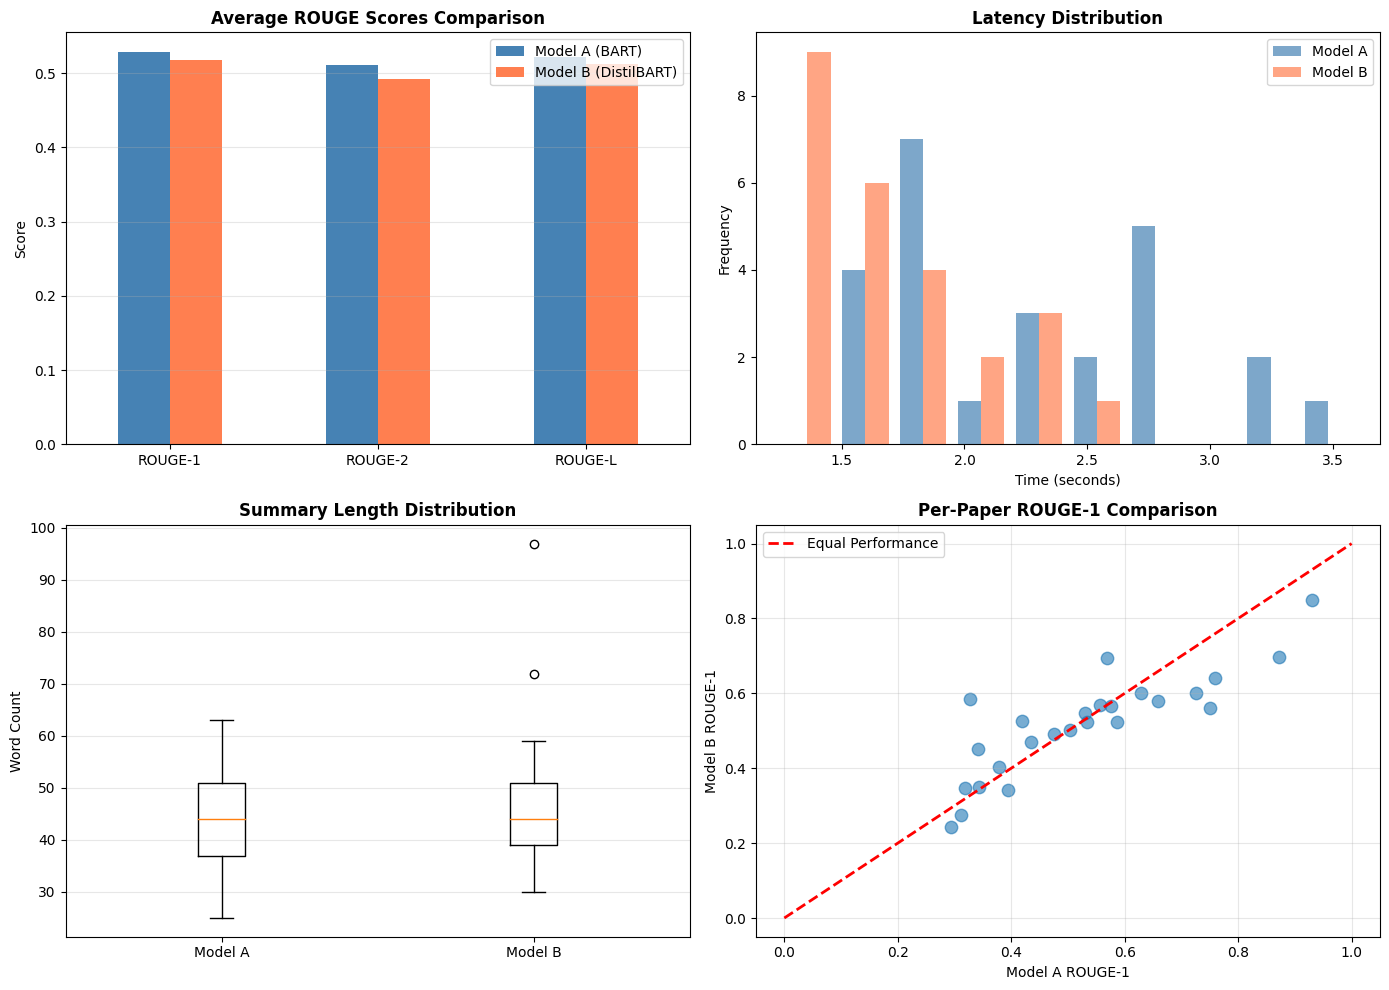

In [10]:
# ================================
# 8. VISUALIZATIONS
# ================================

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ROUGE Score Comparison
rouge_comparison = pd.DataFrame({
    'Model A (BART)': df_rouge_a.mean(),
    'Model B (DistilBART)': df_rouge_b.mean()
})
rouge_comparison.plot(kind='bar', ax=axes[0, 0], color=['steelblue', 'coral'])
axes[0, 0].set_title('Average ROUGE Scores Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xticklabels(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'], rotation=0)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)




# 2. Latency Distribution
axes[0, 1].hist([df_results['latency_a'], df_results['latency_b']], 
                bins=10, label=['Model A', 'Model B'], 
                color=['steelblue', 'coral'], alpha=0.7)
axes[0, 1].set_title('Latency Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Time (seconds)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Summary Length Comparison
axes[1, 0].boxplot([df_results['length_a'], df_results['length_b']], 
                    labels=['Model A', 'Model B'])
axes[1, 0].set_title('Summary Length Distribution', fontweight='bold')
axes[1, 0].set_ylabel('Word Count')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. ROUGE-1 Scatter Plot
axes[1, 1].scatter(df_rouge_a['rouge1'], df_rouge_b['rouge1'], alpha=0.6, s=80)
axes[1, 1].plot([0, 1], [0, 1], 'r--', lw=2, label='Equal Performance')
axes[1, 1].set_xlabel('Model A ROUGE-1')
axes[1, 1].set_ylabel('Model B ROUGE-1')
axes[1, 1].set_title('Per-Paper ROUGE-1 Comparison', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ab_test_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: ab_test_analysis.png")


In [11]:
# ================================
# 9. SUMMARY REPORT
# ================================

print("\n" + "="*60)
print("A/B TEST SUMMARY REPORT")
print("="*60)

report = f"""
EXPERIMENTAL RESULTS
{'='*60}

Sample Size: {len(df_results)} papers

ROUGE Scores (Average):
  Model A (BART):
    - ROUGE-1: {df_rouge_a['rouge1'].mean():.4f}
    - ROUGE-2: {df_rouge_a['rouge2'].mean():.4f}
    - ROUGE-L: {df_rouge_a['rougeL'].mean():.4f}
  
  Model B (DistilBART):
    - ROUGE-1: {df_rouge_b['rouge1'].mean():.4f}
    - ROUGE-2: {df_rouge_b['rouge2'].mean():.4f}
    - ROUGE-L: {df_rouge_b['rougeL'].mean():.4f}

Statistical Significance:
  - p-value: {p_value:.4f}
  - Cohen's d: {cohens_d:.4f}
  - 95% CI: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]

Latency Performance:
  - Model A: {df_results['latency_a'].mean():.2f}s (±{df_results['latency_a'].std():.2f}s)
  - Model B: {df_results['latency_b'].mean():.2f}s (±{df_results['latency_b'].std():.2f}s)

RECOMMENDATION:
{'='*60}
"""

if p_value < 0.05:
    better_model = "Model A (BART)" if mean_diff > 0 else "Model B (DistilBART)"
    report += f"✓ {better_model} shows statistically significant better performance.\n"
else:
    report += "✗ No statistically significant difference detected.\n"
    report += "  Consider: longer test period, larger sample size, or user preference data.\n"

print(report)

# Save report
# FIX: Add encoding='utf-8' argument to open()
with open('../data/ab_test_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)
print("\n✓ Report saved to ../data/ab_test_report.txt")


A/B TEST SUMMARY REPORT

EXPERIMENTAL RESULTS

Sample Size: 25 papers

ROUGE Scores (Average):
  Model A (BART):
    - ROUGE-1: 0.5287
    - ROUGE-2: 0.5111
    - ROUGE-L: 0.5216
  
  Model B (DistilBART):
    - ROUGE-1: 0.5174
    - ROUGE-2: 0.4925
    - ROUGE-L: 0.5123

Statistical Significance:
  - p-value: 0.5652
  - Cohen's d: 0.0703
  - 95% CI: [-0.0287, 0.0513]

Latency Performance:
  - Model A: 2.29s (±0.57s)
  - Model B: 1.71s (±0.38s)

RECOMMENDATION:
✗ No statistically significant difference detected.
  Consider: longer test period, larger sample size, or user preference data.


✓ Report saved to ../data/ab_test_report.txt


In [16]:
# ================================
# 10. PREPARE FOR USER STUDY
# ================================

print("\n" + "="*60)
print("NEXT STEPS: USER PREFERENCE COLLECTION")
print("="*60)

print("""
The automated evaluation is complete. Next steps:

1. Deploy Streamlit app with A/B testing interface
2. Collect user preferences:
    - Show summaries from both models (blind test)
    - Ask users: "Which summary is better?"
    - Log responses to ab_test_logs.csv

3. Analyze user preference data:
    - Calculate preference rate for each model
    - Chi-square test for significance
    - Combine with ROUGE scores for final decision

4. Make final model selection based on:
    - Automated metrics (ROUGE)
    - User preferences
    - Latency considerations
    - Cost/resource constraints
""")

print("\n✅ A/B testing analysis complete!")
print("Ready to build Streamlit app for user study")
print("="*60)


NEXT STEPS: USER PREFERENCE COLLECTION

The automated evaluation is complete. Next steps:

1. Deploy Streamlit app with A/B testing interface
2. Collect user preferences:
    - Show summaries from both models (blind test)
    - Ask users: "Which summary is better?"
    - Log responses to ab_test_logs.csv

3. Analyze user preference data:
    - Calculate preference rate for each model
    - Chi-square test for significance
    - Combine with ROUGE scores for final decision

4. Make final model selection based on:
    - Automated metrics (ROUGE)
    - User preferences
    - Latency considerations
    - Cost/resource constraints


✅ A/B testing analysis complete!
Ready to build Streamlit app for user study
